In [140]:
using Pkg
Pkg.activate("..")
using Revise
using Gen
using DataFrames
using Logging
using Plots

  Activating project at `~/src/mit/BayesAir.jl`


In [141]:
using BayesAir

In [142]:
global_logger(ConsoleLogger(stderr, Logging.Info));

In [143]:
# Define a simple schedule sending the aircraft back and forth between two airports
states = Vector{BayesAir.NetworkState}()
for _ in 1:3
    flight_schedule = DataFrame(
        :flight_number => ["F1", "F2", "F3"],
        :origin => ["BOS", "BOS", "JFK"],
        :destination => ["JFK", "JFK", "BOS"],
        :scheduled_departure_time => [0.0, 0.05, 2.0],
        :scheduled_arrival_time => [1.0, 1.05, 3.5],
        :actual_departure_time => [0.0 + rand() * 0.3, 4.0 + rand() * 0.3, 2.0 + rand() * 0.3],
        :actual_arrival_time => [1.0 + rand() * 0.3, 5.0 + rand() * 0.3, 3.5 + rand() * 0.3],
    )
    flights, airports = BayesAir.parse_schedule(flight_schedule)
    push!(airports[1].available_aircraft, 0.0)
    push!(airports[1].available_crew, 0.0)

    airport_dict = Dict{String, BayesAir.Airport}()
    for airport in airports
        airport_dict[airport.code] = airport
    end

    state = BayesAir.NetworkState(airport_dict, flights |> Vector{BayesAir.Flight})
    push!(states, state)
end

In [149]:
# Trace the simulation using Gen and see the random choices made by the simulator
hrs = 12.0
dt = 0.1
trace = Gen.simulate(BayesAir.simulate, (states, hrs, dt));
Gen.get_choices(trace)

│
├── ("BOS", :service_time) : 0.02230831179174695
│
├── ("BOS", "JFK", :travel_time) : 4.437629066508363
│
├── ("JFK", "BOS", :travel_time) : 3.800434138679174
│
├── ("BOS", :turnaround_time) : 0.8676823227129145
│
├── :travel_time_variation : 0.03154655557861801
│
├── :turnaround_time_variation : 0.05087049139770882
│
├── :measurement_variation : 0.008736477477077764
│
├── ("JFK", :turnaround_time) : 0.9022219650846156
│
├── ("JFK", :service_time) : 0.07070056497720341
│
├── (:day, 2)
│   │
│   ├── ("F1 BOS->JFK", :actual_departure_time) : 0.02027303761574472
│   │
│   ├── ("F3 JFK->BOS", :arrival_service_time) : 0.0037367937297831375
│   │
│   ├── ("F1 BOS->JFK", :travel_time) : 4.501741692762058
│   │
│   ├── ("F1 BOS->JFK", :arrival_service_time) : 0.02875296651806216
│   │
│   ├── ("F2 BOS->JFK", :travel_time) : 4.56128485265471
│   │
│   ├── ("F3 JFK->BOS", :departure_service_time) : 0.02936004785501501
│   │
│   ├── ("F2 BOS->JFK", :departure_service_time) : 0.01126689068591423

In [6]:
# Define a function for doing posterior inference. can we back out the travel times?
# Let's start by using dead-simple importance sampling
function do_importance_sampling(model, states, hrs, dt, num_samples)
    # Create a choice map that maps the actual departure and arrival times to the
    # observed values.
    observations = Gen.choicemap()
    for (i, state) in enumerate(states)
        for flight in state.pending_flights
            observations[(:day, i) => (BayesAir.flight_code(flight), :actual_departure_time)] = flight.actual_departure_time
            observations[(:day, i) => (BayesAir.flight_code(flight), :actual_arrival_time)] = flight.actual_arrival_time
        end
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (traces, log_norm_weights, _) = Gen.importance_sampling(model, (states, hrs, dt), observations, num_samples);
    return traces, log_norm_weights
end;

In [158]:
function render_traces(traces, weights=nothing)
    # Make a scatter plot of the travel times for each trace
    bos_jfk_travel_times = Vector{Float64}()
    jfk_bos_travel_times = Vector{Float64}()
    for trace in traces
        push!(bos_jfk_travel_times, trace[("BOS", "JFK", :travel_time)])
        push!(jfk_bos_travel_times, trace[("JFK", "BOS", :travel_time)])
    end

    # Make a histogram of the travel time, using weights if provided
    if !isnothing(weights)
        fig = histogram2d(
            bos_jfk_travel_times,
            jfk_bos_travel_times;
            bins=(100, 100),
            weights=weights,
            xlabel="BOS -> JFK",
            ylabel="JFK -> BOS",
            legend=false,
            colorbar=true,
            show_empty_bins=true,
            color=:plasma,
            xlims = (-10,10),
            ylims = (-10,10)
        )
    else
        fig = scatter(
            bos_jfk_travel_times,
            jfk_bos_travel_times;
            xlabel="BOS -> JFK",
            ylabel="JFK -> BOS",
            legend=false,
            xlims = (-10,10),
            ylims = (-10,10)
        )
    end

    return fig
end;

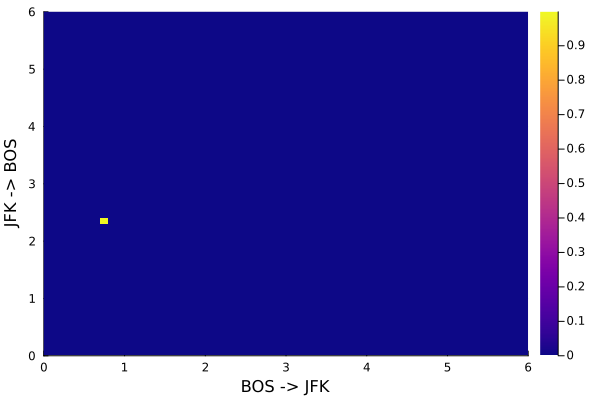

In [8]:
amount_of_compute = 1000  # should be 100000 for accurate estimates, but that takes a long time...
traces, log_weights = do_importance_sampling(BayesAir.simulate, states, 24.0, dt, amount_of_compute)
render_traces(traces, exp.(log_weights))

In [151]:
@gen function system_parameter_proposal(trace, width)
    # Resample the system parameters
    {:measurement_variation} ~ uniform(
        max(0.0, trace[:measurement_variation] - width / 2),
        min(trace[:measurement_variation] + width / 2, 0.1)
    )
    {:travel_time_variation} ~ uniform(
        max(0.0, trace[:travel_time_variation] - width / 2),
        min(trace[:travel_time_variation] + width / 2, 0.1)
    )
    {:turnaround_time_variation} ~ uniform(
        max(0.0, trace[:turnaround_time_variation] - width / 2),
        min(trace[:turnaround_time_variation] + width / 2, 0.1)
    )
end

@gen function airport_parameter_proposal(trace, airport_code::BayesAir.AirportCode, width)
    # Resample the parameters for the given airport
    {(airport_code, :turnaround_time)} ~ uniform(
        max(0.0, trace[(airport_code, :turnaround_time)] - width / 2),
        min(trace[(airport_code, :turnaround_time)] + width / 2, 1.0)
    )
    {(airport_code, :service_time)} ~ uniform(
        max(0.0, trace[(airport_code, :service_time)] - width * 0.1 / 2),
        min(trace[(airport_code, :service_time)] + width * 0.1 / 2, 0.1)
    )
end

@gen function all_airport_parameter_proposal(trace, airport_codes, width)
    for airport_code in airport_codes
        {*} ~ airport_parameter_proposal(trace, airport_code, width)
    end
end

@gen function travel_times_proposal(trace, airport_codes, width)
    # Resample mean travel times for all routes
    nominal_travel_times = Dict{Tuple{BayesAir.AirportCode, BayesAir.AirportCode}, Float64}()
    for origin_code in airport_codes
        for destination_code in airport_codes
            if origin_code != destination_code
                key = (origin_code, destination_code, :travel_time)
                min_t = max(0.0, trace[key] - width / 2)
                max_t = min(trace[key] + width / 2, 6.0)
                nominal_travel_times[(origin_code, destination_code)] = {key} ~ uniform(
                    min_t, max_t
                )
            end
        end
    end

    # Resample actual travel and service times for all routes
    for (i, state) in enumerate(Gen.get_args(trace)[1])
        for flight in state.pending_flights
            travel_time_key = (:day, i) => (BayesAir.flight_code(flight), :travel_time)
            realized_travel_time = {travel_time_key} ~ normal(
                nominal_travel_times[(flight.origin, flight.destination)],
                nominal_travel_times[(flight.origin, flight.destination)] * trace[:travel_time_variation]
            )

            departure_service_key = (:day, i) => (BayesAir.flight_code(flight), :departure_service_time)
            {departure_service_key} ~ exponential(1 / trace[(flight.origin, :service_time)])

            arrival_service_key = (:day, i) => (BayesAir.flight_code(flight), :arrival_service_time)
            {arrival_service_key} ~ exponential(1 / trace[(flight.destination, :service_time)])
        end
    end
end

function gaussian_drift_update(trace, width, constraints)
    # Get a list of all airports
    airport_codes = keys(Gen.get_args(trace)[1][1].airports)

    (trace, system_params_accepted) = mh(trace, system_parameter_proposal, (width,), check=true, observations=constraints)
    (trace, airport_params_accepted) = mh(trace, all_airport_parameter_proposal, (airport_codes, width), check=true, observations=constraints)
    (trace, travel_times_accepted) = mh(trace, travel_times_proposal, (airport_codes, width), check=true, observations=constraints)

    return trace, Dict(
        :system_params => system_params_accepted,
        :airport_params => airport_params_accepted,
        :travel_times => travel_times_accepted,
    )
end;

function do_mcmc_inference(model, states, hrs, dt, num_samples, burn_in_samples, width)
    # Make constraints based on actual departure and arrival times
    constraints = Gen.choicemap()
    for (i, state) in enumerate(states)
        for flight in state.pending_flights
            constraints[(:day, i) => (BayesAir.flight_code(flight), :actual_departure_time)] = flight.actual_departure_time
            constraints[(:day, i) => (BayesAir.flight_code(flight), :actual_arrival_time)] = flight.actual_arrival_time
        end
    end

    # Get an initial trace
    (trace, _) = Gen.generate(model, (states, hrs, dt), constraints)

    # Run the burn-in
    for _ in 1:burn_in_samples
        trace, _ = gaussian_drift_update(trace, width, constraints)
    end

    # Run the main loop
    scores = Vector{Float64}()
    traces = Vector{Gen.DynamicDSLTrace}()
    acceptance_rates = Dict()
    for _ in 1:num_samples
        trace, accepted = gaussian_drift_update(trace, width, constraints)
        push!(traces, trace)
        push!(scores, Gen.get_score(trace))

        # Update acceptance rates
        for (key, value) in accepted
            if !haskey(acceptance_rates, key)
                acceptance_rates[key] = 0.0
            end

            acceptance_rates[key] = acceptance_rates[key] + value / num_samples
        end
    end

    return traces, scores, acceptance_rates
end;

In [161]:
all_traces = Vector{Any}()
trace_figs = Vector{Plots.Plot{Plots.GRBackend}}()
scores = Vector{Vector{Float64}}()
average_acceptance_rates = Dict()
n_chains = 4
for _ in 1:n_chains
    traces, trace_scores, acceptance_rates = do_mcmc_inference(BayesAir.simulate, states, 24.0, dt, 500, 500, 0.5)
    push!(trace_figs, render_traces(traces))
    push!(all_traces, traces)
    push!(scores, trace_scores)
    for (key, value) in acceptance_rates
        if !haskey(average_acceptance_rates, key)
            average_acceptance_rates[key] = 0.0
        end
        average_acceptance_rates[key] = average_acceptance_rates[key] + value / n_chains
    end
end
@show average_acceptance_rates
Plots.plot([s for s in scores])

DomainError: DomainError with -0.047583164911566375:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [156]:
average_acceptance_rates

Dict{Any, Any} with 3 entries:
  :travel_times   => 0.006
  :airport_params => 0.069
  :system_params  => 0.041

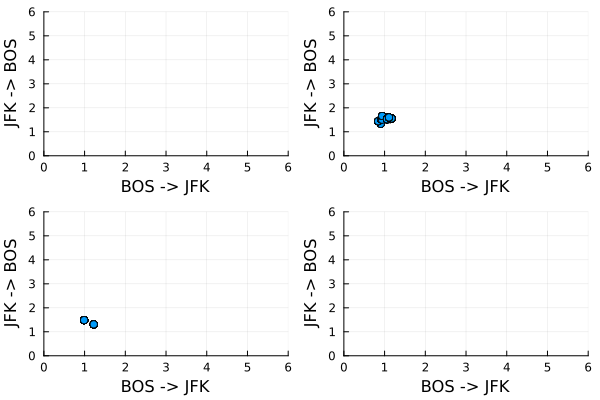

In [160]:
Plots.plot(trace_figs...)